## Dynamic Cascade Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML
import seaborn as sns

%matplotlib inline

In [2]:
trm18 = pd.read_csv("IxI_18.csv", index_col=0) #total requirements matrix
trm18_mat = trm18.to_numpy() # just a numpy version of the trm, if needed?
back_link18 = trm18.sum(axis=0) # backwards links or total input requirements

def shock(industry, beta, p_c, T):
    
    global cascade
    global fail_list
    global frac_survived_list
    global step
    fail_list = []
    frac_survived_list = [(0,1)]
    cascade = trm18_mat.copy()
    prev_backlink = back_link18.copy()
    step = 0
    
    for i in range(0,len(cascade)):
        cascade[industry][i] = beta*cascade[industry][i]
    
    return spread(p_c, T,prev_backlink,step)

In [29]:
def spread(p_c, T,prev_backlink,step):
    
    current_backlink = cascade.sum(axis=0) #column sums 
    
    for i in range(0,len(cascade)):
        p = current_backlink[i]/prev_backlink[i]
        for j in range(0,len(cascade)):
            if (1-p) > p_c:
                cascade[i][j] = 0
                if i not in fail_list:
                    fail_list.append(i)
            else:
                cascade[i][j] = p*cascade[i][j]
                
    prev_backlink = current_backlink
    step += 1
                
    #print(fail_list)
            
    return check(p_c, T,prev_backlink,step)
    
def check(p_c, T,prev_backlink,step):
    
    current_fail = len(fail_list)
    
    if (step==T): # use this line for making heat maps
    #if (step == T) or (current_fail == len(cascade)): # use this line for eveything else
        frac_survived = (1-current_fail/len(cascade))
        frac_survived_list.append((step,frac_survived))
        prev_backlink = trm18.sum(axis=0) # backwards links or total input requirements
       # print("------------Simulation Over--------------")
        #print("")
        return frac_survived_list
    
    else:
        #print("------cascading-------")
        frac_survived = (1-current_fail/len(cascade))
        frac_survived_list.append((step,frac_survived))
        spread(p_c, T,prev_backlink,step)

## Plots

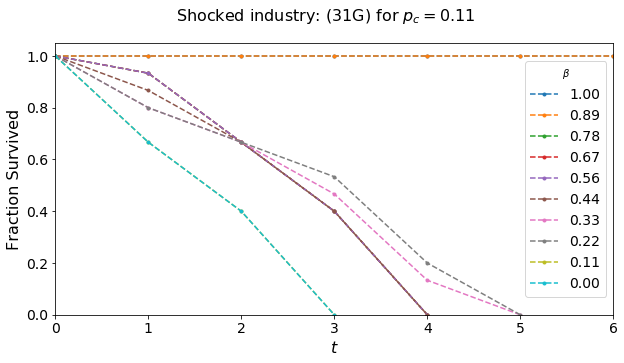

In [28]:
# for one shot plot, one industry, many beta, one p_c

fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlim(0,6)
ax.set_ylim(0,1.05)
ax.set_xlabel(r'$t$',fontsize=16)
ax.set_ylabel("Fraction Survived",fontsize=16)
ax.tick_params(axis='both', labelsize=14)
fig.suptitle("Shocked industry: (31G) for $p_c = 0.11$",fontsize=16)

ind = 4
#for beta in np.linspace(1,0,10): #this last parameter is how many lines to plot
for beta in np.linspace(1,0,10):
    x,y = [],[]
    shock(ind,beta,.11,10) # industry, beta, p_c, T
    for k in range(0,len(frac_survived_list)):
        x.append(frac_survived_list[k][0])
        y.append(frac_survived_list[k][1])
    ax.plot(x,y,'--.',label="%.2f" % beta)
ax.legend(loc='center right',title=r'$\beta$',fontsize=14)

## Animation

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


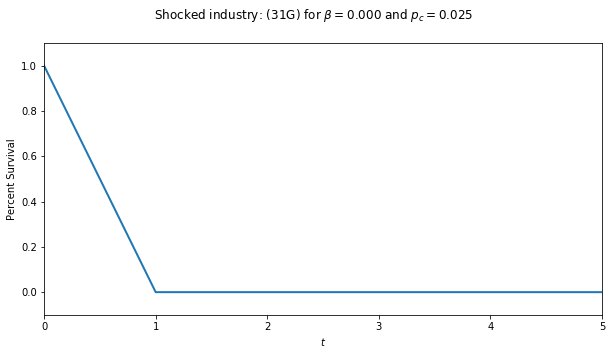

In [61]:
#animation of one industry, many beta, one p_C

fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_xlim(0,5)
ax1.set_ylim(-0.1,1.1)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel("Percent Survival")
x,y = [],[]
line, = ax1.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = []
    y = []
    shock(4,i,0.025,5) #industry, beta, p_c, T
    for k in range(0,len(frac_survived_list)):
        x.append(frac_survived_list[k][0])
        y.append(frac_survived_list[k][1])
    line.set_data(x, y)
    fig1.suptitle("Shocked industry: (31G) for " + r'$\beta = %.3f$' % i + " and " + r'$p_c = 0.025$')
    return (line,)
    
anim = animation.FuncAnimation(fig1, animate, init_func=init,
                               frames=np.linspace(1,0,100), interval=100, blit=True)

#rc('animation', html='html5')
HTML(anim.to_html5_video())
#anim.save("31G_dyn_025.mp4")

## Heatmap, all parameters at one t value

In [45]:
fracsurvive = []
delta = 201
gammacut = 0.25
ind = 4
time = 1

for pc in np.linspace(0,gammacut,delta):
    for beta in np.linspace(0,1,delta):
        shock(ind,beta,pc,time)
        fracsurvive.append(frac_survived_list[time][1])
        
fracsurvive = np.array(fracsurvive).reshape(delta,delta)

In [46]:
df = pd.DataFrame(fracsurvive, columns = np.linspace(0,1,delta), index=np.linspace(0,gammacut,delta))
df1 = pd.DataFrame(df.iloc[0:,0:], columns = np.linspace(0,1,delta), index=np.linspace(0,gammacut,delta))

Text(0.5, 1, 'Stable/Unstable regions for 31G, t = 1')

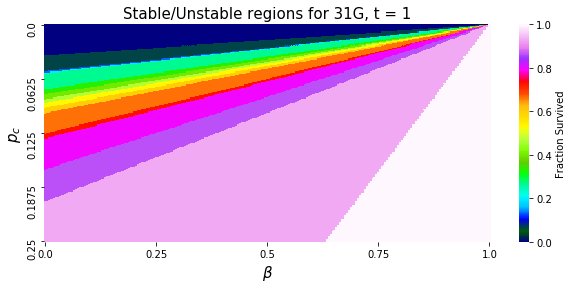

In [47]:
dict = {'0':'11','1':'21','2':'22','3':'23','4':'31G','5':'42','6':'44RT',
        '7':'48TW','8':'51','9':'FIRE','10':'PROF','11':'6','12':'7','13':'81','14':'G'}

cmap = sns.cubehelix_palette(18, start=2, rot=4, dark=0, light=0.7, reverse=True)
cmap1 = 'gist_ncar'
plt.figure(figsize=(10,4))
ax=sns.heatmap(df1,cmap=cmap1,xticklabels=50,yticklabels=50,cbar_kws={'label': 'Fraction Survived'})
ax.set_xlabel(r'$\beta$',fontsize=15)
ax.set_ylabel(r'$p_c$',fontsize=15)
ax.set_title("Stable/Unstable regions for " + dict['%d' % ind] + ", t = %d" % time,fontsize=15)